Compare the psf_fwhm value from PSFEx with the NEA-derived FWHM value

In [1]:
from __future__ import division, print_function
import sys, os, glob, time, warnings, gc
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack, hstack, join
import fitsio
# from astropy.io import fits

import postage

In [2]:
params = {'legend.fontsize': 'x-large',
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large',
          'figure.facecolor': 'w'}
plt.rcParams.update(params)

In [3]:
cat = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/dr10dev/misc/survey-ccds-dr10-v4-psfex-fwhm.fits'))
print(len(cat))
dr9 = Table(fitsio.read('/global/cfs/cdirs/cosmo/data/legacysurvey/dr9/survey-ccds-decam-dr9.fits.gz', columns=['expnum', 'ccdname', 'ccd_cuts', 'filter']))
print(len(dr9))

cat['ccd_id_str'] = np.char.add(np.array(cat['expnum']).astype(str), cat['ccdname'])
dr9['ccd_id_str'] = np.char.add(np.array(dr9['expnum']).astype(str), dr9['ccdname'])

mask = dr9['ccd_cuts']==0
dr9 = dr9[mask]
print(len(dr9))

cat = join(cat, dr9[['ccd_id_str', 'filter']], keys='ccd_id_str', join_type='inner')
print(len(cat))

ccd = Table(fitsio.read('/global/cfs/cdirs/desi/users/rongpu/useful/survey-ccds-decam-dr9-trim.fits'))
cat = join(cat, ccd[['expnum', 'image_filename']])

cat_all = cat.copy()

15523579
6388340
4891222
4891222


In [4]:
tmp = Table()
tmp['filter'], tmp['count'] = np.unique(cat['filter'], return_counts=True)
tmp.sort('count')
tmp

filter,count
str1,int64
r,1567932
g,1641479
z,1681811


In [50]:
np.random.seed(929)
idx = np.random.choice(len(cat_all), size=(10000), replace=False)
cat = cat_all[idx].copy()

In [51]:
psf_fwhm = []
psf_fwhm_nea = []

for index in range(len(cat)):
    image_filename = cat['image_filename'][index]
    psfex_filename = image_filename[:image_filename.find('.fits.fz')]+'-psfex.fits'
    psfex_path = os.path.join('/global/cfs/projectdirs/cosmo/work/legacysurvey/dr9/calib/psfex', psfex_filename)
    psfex = Table(fitsio.read(psfex_path))
    ii = np.where(psfex['ccdname']==cat['ccdname'][index])[0][0]
    psf_fwhm.append(psfex['psf_fwhm'][ii])
    img = np.array(psfex['psf_mask'][ii][0])
    nea = np.sum(img)**2/np.sum(img**2)
    fwhm = np.sqrt(nea / (4 * np.pi)) * 2.3548  # FWHM a la tractor
    psf_fwhm_nea.append(fwhm)
    
psf_fwhm = np.array(psf_fwhm)
psf_fwhm_nea = np.array(psf_fwhm_nea)

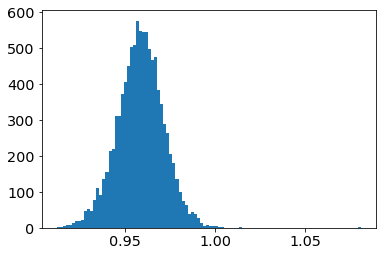

In [52]:
plt.hist(psf_fwhm/psf_fwhm_nea, 100);

0.9633368238737615
0.959921455913624
0.952237674575612


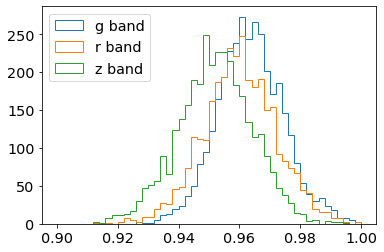

In [53]:
for band in ['g', 'r', 'z']:
    mask = cat['filter']==band
    print(np.median((psf_fwhm/psf_fwhm_nea)[mask]))
    plt.hist((psf_fwhm/psf_fwhm_nea)[mask], 50, alpha=1, range=(0.9, 1.), histtype='step', label=band+' band')
plt.legend(loc='upper left')
plt.show()

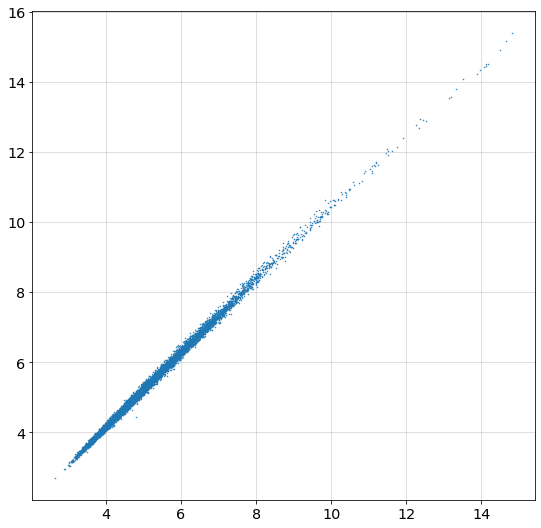

In [54]:
plt.figure(figsize=(9, 9))
plt.plot(psf_fwhm, psf_fwhm_nea, '.', ms=1)
plt.grid(alpha=0.5)
plt.show()

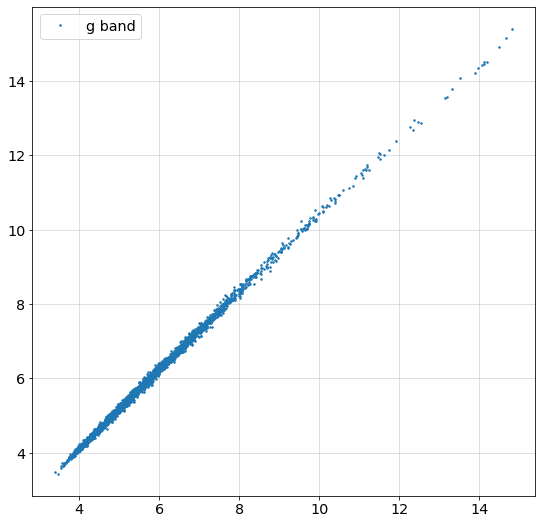

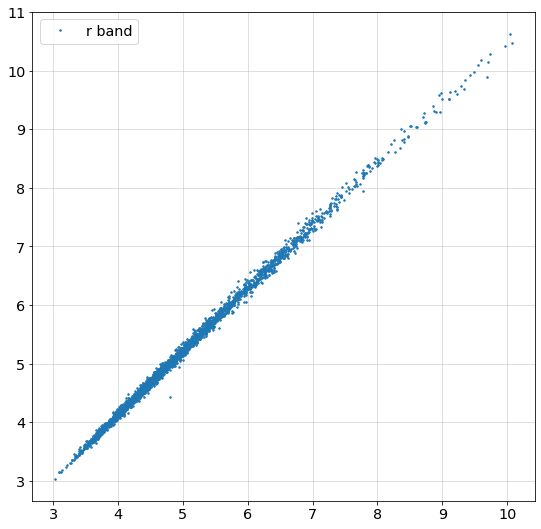

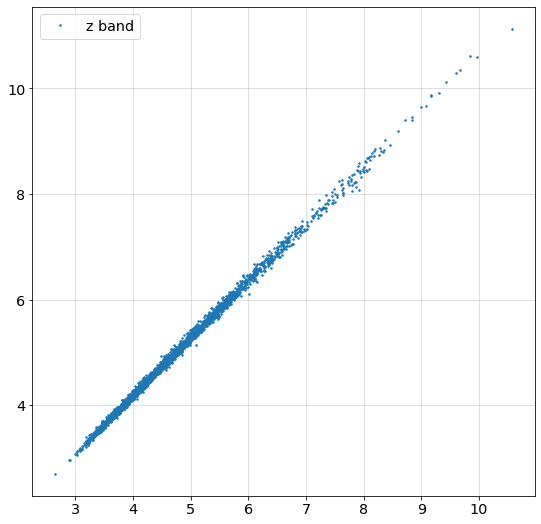

In [55]:
for band in ['g', 'r', 'z']:
    plt.figure(figsize=(9, 9))
    mask = cat['filter']==band
    plt.plot(psf_fwhm[mask], psf_fwhm_nea[mask], '.', ms=3, alpha=1, label=band+' band')
    plt.legend(loc='upper left')
    plt.grid(alpha=0.5)
    plt.show()